# U-Net for Image Segmentation

* The Montgomery datast
* With CV and embedded Early Stopping to avoid overfitting.

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

# Directories for Montgomery dataset images and masks
image_dir = r'C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Datasets\ImageSegmentation\Montgomery_Dataset\CXR_png'
left_mask_dir = r'C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Datasets\ImageSegmentation\Montgomery_Dataset\Masks_png\leftMask'
right_mask_dir = r'C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Datasets\ImageSegmentation\Montgomery_Dataset\Masks_png\rightMask'

img_size = (256, 256)

def load_images_and_masks(image_dir, left_mask_dir, right_mask_dir, img_size):
    images = []
    masks = []
    
    for img_name in os.listdir(image_dir):
        # No need to append .png since the filenames already have it
        img_path = os.path.join(image_dir, img_name)
        left_mask_path = os.path.join(left_mask_dir, img_name)
        right_mask_path = os.path.join(right_mask_dir, img_name)
        
        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Ensure the image is loaded correctly
        if img is None:
            print(f"Image not found: {img_path}")
            continue
        
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize image to range 0-1
        
        # Load left and right lung masks
        left_mask = cv2.imread(left_mask_path, cv2.IMREAD_GRAYSCALE)
        right_mask = cv2.imread(right_mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Ensure both masks are loaded correctly
        if left_mask is None or right_mask is None:
            print(f"Mask not found: {left_mask_path} or {right_mask_path}")
            continue
        
        left_mask = cv2.resize(left_mask, img_size)
        right_mask = cv2.resize(right_mask, img_size)
        
        # Combine left and right masks into a single mask
        combined_mask = np.maximum(left_mask, right_mask)
        combined_mask = combined_mask / 255.0  # Normalize mask to range 0-1
        
        # Append the image and the mask
        images.append(np.expand_dims(img, axis=-1))  # Add channel dimension to the image
        masks.append(np.expand_dims(combined_mask, axis=-1))  # Add channel dimension to the mask
    
    return np.array(images), np.array(masks)

# Load the images and combined masks
images, masks = load_images_and_masks(image_dir, left_mask_dir, right_mask_dir, img_size)

# Ensure data was loaded correctly
if len(images) == 0 or len(masks) == 0:
    raise ValueError("No images or masks were loaded. Check the dataset paths and file names.")

# U-Net Architecture
def unet_model(input_size=(256, 256, 1)):
    inputs = tf.keras.layers.Input(input_size)
    
    # Contracting Path
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c3)
    
    # Bottleneck
    b = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    b = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(b)
    
    # Expansive Path
    u1 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(b)
    u1 = tf.keras.layers.concatenate([u1, c3])
    c4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(u1)
    c4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c4)
    
    u2 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c4)
    u2 = tf.keras.layers.concatenate([u2, c2])
    c5 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c5 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c5)
    
    u3 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c5)
    u3 = tf.keras.layers.concatenate([u3, c1])
    c6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    c6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c6)
    
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(c6)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Early stopping callback to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Arrays to store performance metrics for each fold
accuracy_scores = []
recall_scores = []
precision_scores = []
f1_scores = []
specificity_scores = []

# Loop through each fold in the 10-fold cross-validation
for train_index, test_index in kf.split(images):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = masks[train_index], masks[test_index]
    
    # Create the model for each fold
    model = unet_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model with early stopping
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=8, callbacks=[early_stopping], verbose=1)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(np.uint8)  # Ensure binary predictions
    
    y_test_binary = (y_test > 0.5).astype(np.uint8)  # Convert y_test to binary for comparison

    # Calculate performance metrics for this fold
    def calculate_metrics(y_true, y_pred):
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        accuracy = accuracy_score(y_true_flat, y_pred_flat)
        recall = recall_score(y_true_flat, y_pred_flat)
        precision = precision_score(y_true_flat, y_pred_flat)
        f1 = f1_score(y_true_flat, y_pred_flat)
        
        tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat).ravel()
        specificity = tn / (tn + fp)
        
        return accuracy, recall, precision, f1, specificity

    # Calculate metrics for this fold
    accuracy, recall, precision, f1, specificity = calculate_metrics(y_test_binary, y_pred)
    
    # Append metrics to the respective arrays
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)
    specificity_scores.append(specificity)

# Calculate the average performance across all 10 folds
avg_accuracy = np.mean(accuracy_scores)
avg_recall = np.mean(recall_scores)
avg_precision = np.mean(precision_scores)
avg_f1 = np.mean(f1_scores)
avg_specificity = np.mean(specificity_scores)

# Print the average performance metrics
print(f'Average Accuracy: {avg_accuracy:.4f}')
print(f'Average Recall (Sensitivity): {avg_recall:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average F1 Score: {avg_f1:.4f}')
print(f'Average Specificity: {avg_specificity:.4f}')


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 308s 18s/step - accuracy: 0.6711 - loss: 0.6987 - val_accuracy: 0.7376 - val_loss: 0.5244
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 267s 17s/step - accuracy: 0.7505 - loss: 0.4633 - val_accuracy: 0.7376 - val_loss: 0.3808
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 264s 16s/step - accuracy: 0.7381 - loss: 0.3631 - val_accuracy: 0.7376 - val_loss: 0.3461
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 260s 16s/step - accuracy: 0.7978 - loss: 0.3292 - val_accuracy: 0.9075 - val_loss: 0.3041
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 258s 16s/step - accuracy: 0.9273 - loss: 0.2312 - val_accuracy: 0.8824 - val_loss: 0.3208
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 254s 16s/step - accuracy: 0.9240 - loss: 0.2036 - val_accuracy: 0.9441 - val_loss: 0.1476
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 254s 16s/step - accuracy: 0.9498 - loss: 0.1389 - val_accuracy: 0.9441 - val_loss: 0.1508
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 242s 15s/step - accuracy: 0.9541 - loss: 0.1222 - val_accuracy: 0.

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 233s 14s/step - accuracy: 0.6579 - loss: 0.7182 - val_accuracy: 0.7323 - val_loss: 0.5278
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 228s 14s/step - accuracy: 0.7458 - loss: 0.5015 - val_accuracy: 0.7323 - val_loss: 0.3937
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 230s 14s/step - accuracy: 0.7465 - loss: 0.3685 - val_accuracy: 0.7323 - val_loss: 0.3394
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 236s 14s/step - accuracy: 0.6623 - loss: 0.6168 - val_accuracy: 0.7427 - val_loss: 0.4296
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 227s 14s/step - accuracy: 0.7379 - loss: 0.4000 - val_accuracy: 0.9194 - val_loss: 0.3054
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 226s 14s/step - accuracy: 0.9049 - loss: 0.2703 - val_accuracy: 0.9274 - val_loss: 0.1828
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 235s 14s/step - accuracy: 0.6685 - loss: 0.5905 - val_accuracy: 0.7446 - val_loss: 0.3948
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 224s 14s/step - accuracy: 0.7428 - loss: 0.4079 - val_accuracy: 0.7537 - val_loss: 0.3534
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 225s 14s/step - accuracy: 0.8394 - loss: 0.3210 - val_accuracy: 0.9257 - val_loss: 0.2554
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 234s 14s/step - accuracy: 0.6779 - loss: 0.6063 - val_accuracy: 0.7673 - val_loss: 0.3891
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 225s 14s/step - accuracy: 0.7490 - loss: 0.3841 - val_accuracy: 0.8656 - val_loss: 0.3036
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 224s 14s/step - accuracy: 0.8930 - loss: 0.2952 - val_accuracy: 0.9375 - val_loss: 0.2397
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 230s 14s/step - accuracy: 0.6516 - loss: 0.6975 - val_accuracy: 0.7481 - val_loss: 0.5048
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 225s 14s/step - accuracy: 0.7527 - loss: 0.4617 - val_accuracy: 0.7481 - val_loss: 0.3710
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 224s 14s/step - accuracy: 0.7462 - loss: 0.3709 - val_accuracy: 0.8621 - val_loss: 0.3216
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 235s 14s/step - accuracy: 0.7232 - loss: 0.7294 - val_accuracy: 0.7271 - val_loss: 0.5095
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 223s 14s/step - accuracy: 0.7476 - loss: 0.4572 - val_accuracy: 0.7271 - val_loss: 0.3997
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 224s 14s/step - accuracy: 0.7431 - loss: 0.3701 - val_accuracy: 0.7821 - val_loss: 0.3310
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 245s 15s/step - accuracy: 0.6625 - loss: 0.6589 - val_accuracy: 0.7696 - val_loss: 0.4760
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 290s 18s/step - accuracy: 0.7354 - loss: 0.4787 - val_accuracy: 0.7696 - val_loss: 0.3208
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 243s 15s/step - accuracy: 0.7423 - loss: 0.3909 - val_accuracy: 0.7696 - val_loss: 0.3115
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 281s 17s/step - accuracy: 0.7172 - loss: 0.6525 - val_accuracy: 0.7401 - val_loss: 0.5271
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 251s 16s/step - accuracy: 0.7409 - loss: 0.4810 - val_accuracy: 0.7401 - val_loss: 0.3935
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 246s 15s/step - accuracy: 0.7454 - loss: 0.3689 - val_accuracy: 0.8830 - val_loss: 0.3180
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Accuracy: 0.7683
Average Recall (Sensitivity): 0.0931
Average Precision: 0.0968
Average F1 Score: 0.0949
Average Specificity: 0.9989


* Improved code

Starting fold 1...
Epoch 1/50


C:\Users\Jaber\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 583s 36s/step - accuracy: 0.6462 - loss: 0.6457 - val_accuracy: 0.7376 - val_loss: 0.5181
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 552s 34s/step - accuracy: 0.7484 - loss: 0.5046 - val_accuracy: 0.7376 - val_loss: 0.4097
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 547s 34s/step - accuracy: 0.7488 - loss: 0.4680 - val_accuracy: 0.8377 - val_loss: 0.3423
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 550s 34s/step - accuracy: 0.8092 - loss: 0.4156 - val_accuracy: 0.9165 - val_loss: 0.2870
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 574s 36s/step - accuracy: 0.8419 - loss: 0.3517 - val_accuracy: 0.9056 - val_loss: 0.2805
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 575s 36s/step - accuracy: 0.8462 - loss: 0.3509 - val_accuracy: 0.9220 - val_loss: 0.2768
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 562s 35s/step - accuracy: 0.8331 - loss: 0.3473 - val_accuracy: 0.9220 - val_loss: 0.2501
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 559s 35s/step - accuracy: 0.8375 - loss: 0.3412 - val_accuracy: 0.9203 - val_

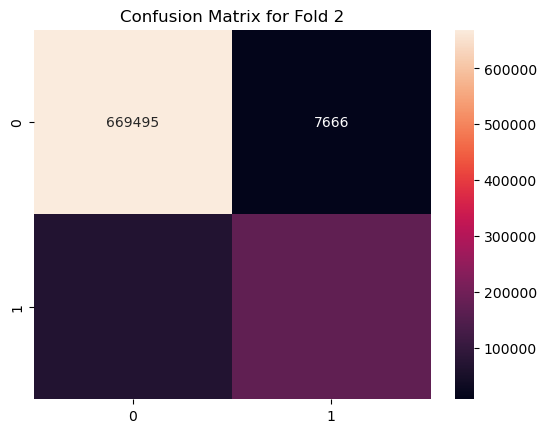

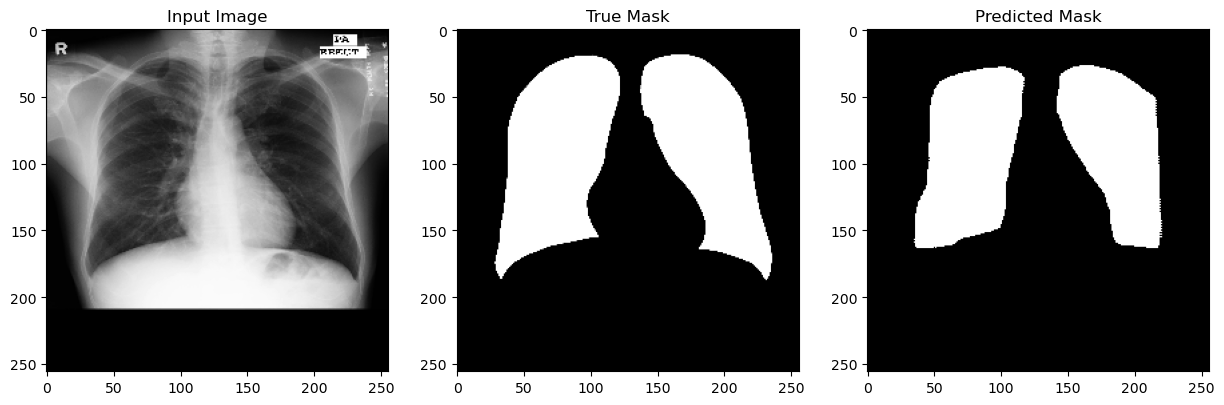

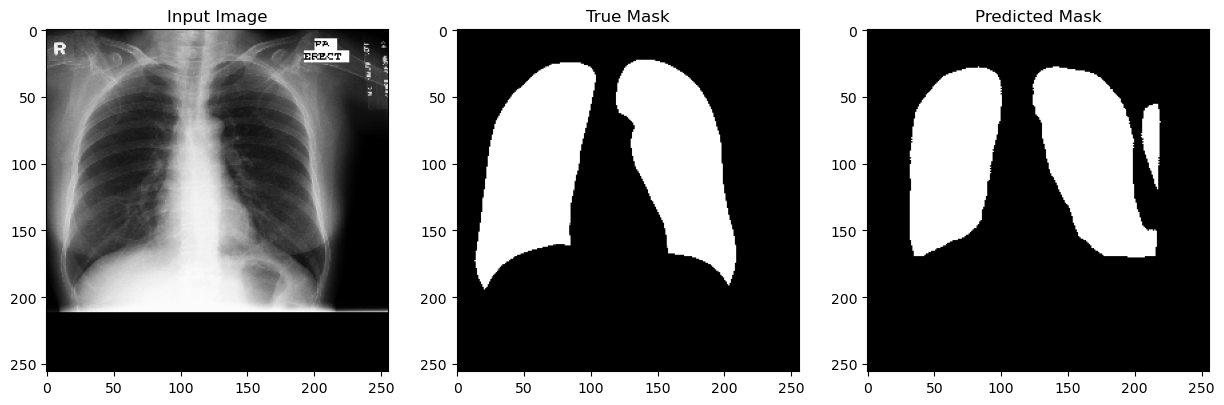

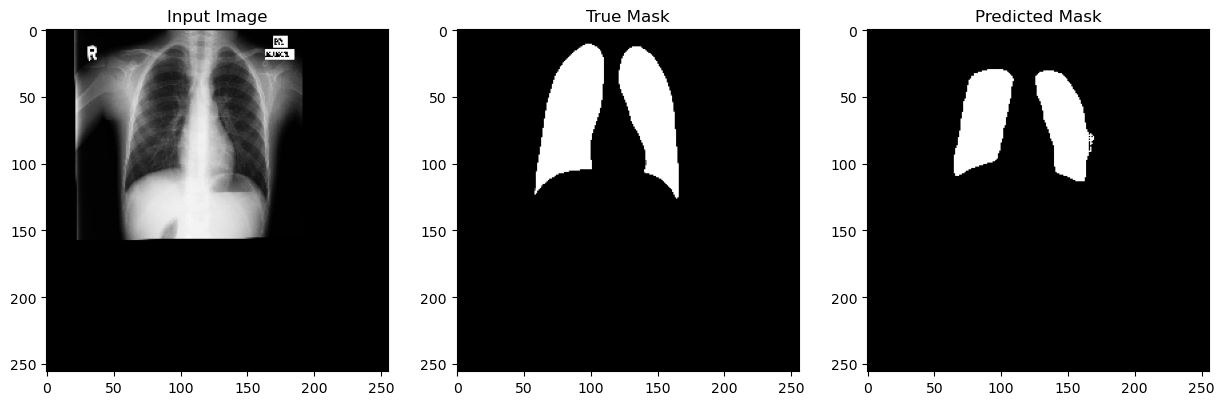

Starting fold 2...
Epoch 1/50


C:\Users\Jaber\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 582s 35s/step - accuracy: 0.7126 - loss: 0.7028 - val_accuracy: 0.7330 - val_loss: 0.5779
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 556s 35s/step - accuracy: 0.7426 - loss: 0.5607 - val_accuracy: 0.7330 - val_loss: 0.4462
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 557s 35s/step - accuracy: 0.7473 - loss: 0.4729 - val_accuracy: 0.7330 - val_loss: 0.4157
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


C:\Users\Jaber\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


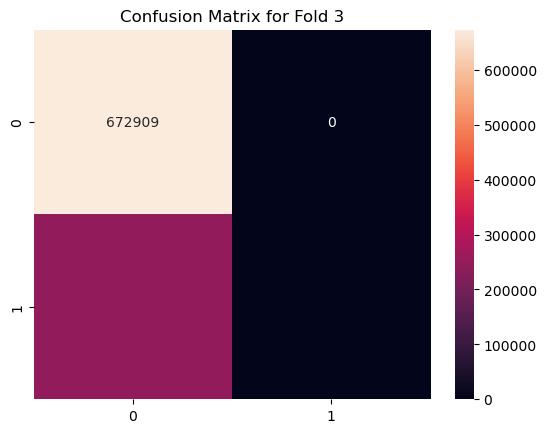

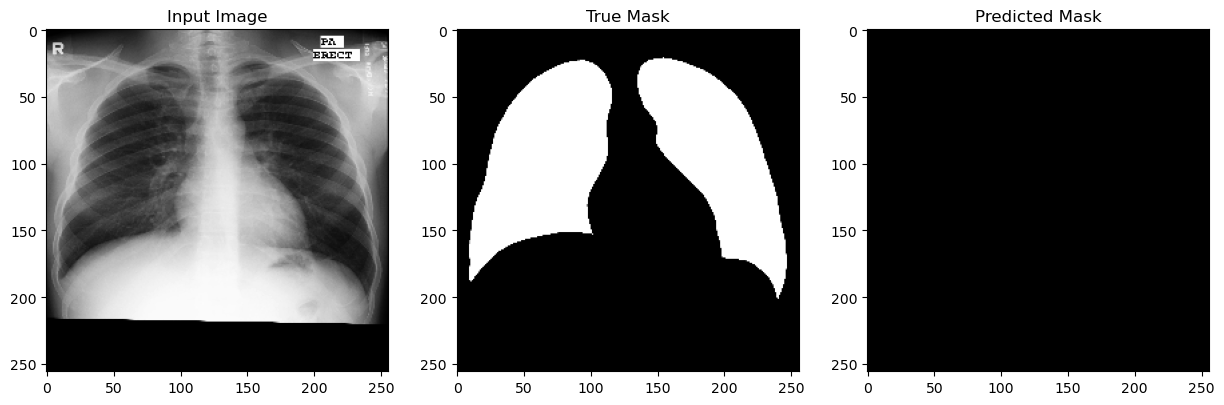

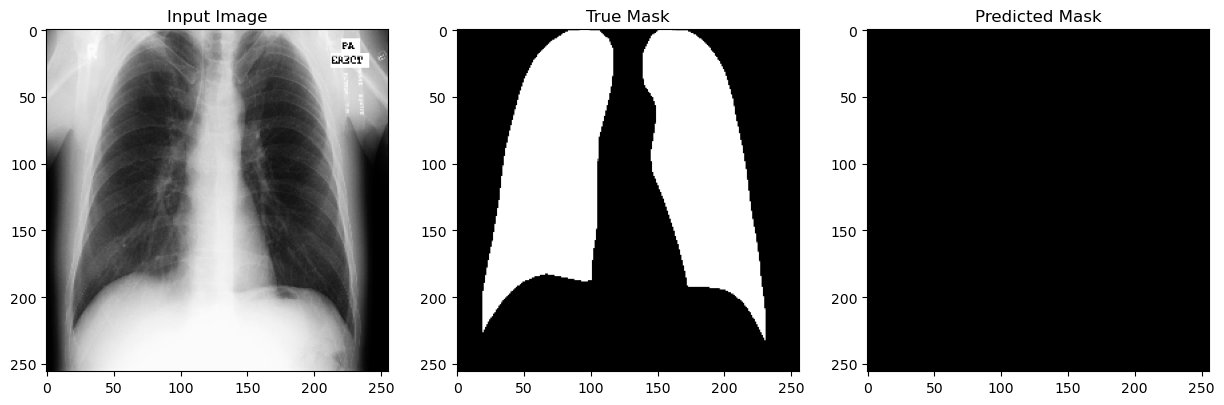

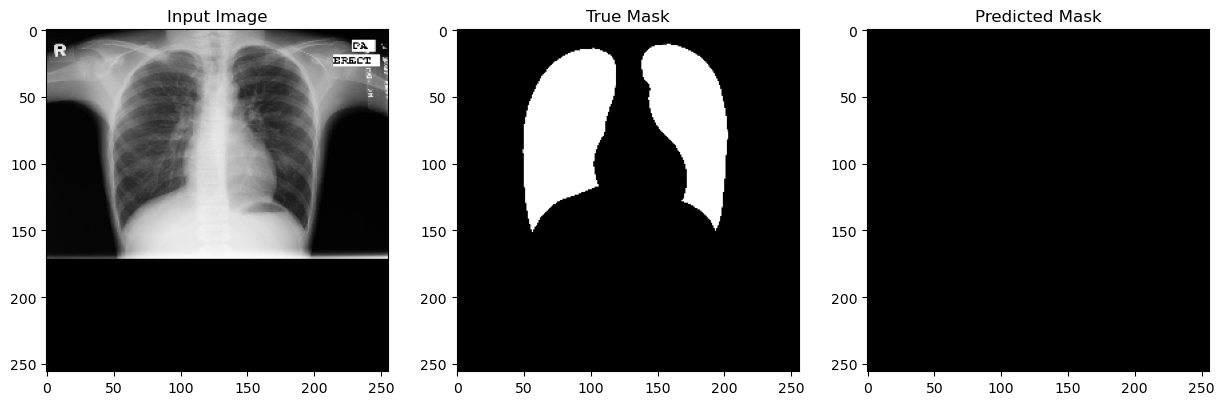

Starting fold 3...
Epoch 1/50


C:\Users\Jaber\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 575s 35s/step - accuracy: 0.7450 - loss: 0.6897 - val_accuracy: 0.7323 - val_loss: 0.4962
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 556s 35s/step - accuracy: 0.7523 - loss: 0.4809 - val_accuracy: 0.7323 - val_loss: 0.4513
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 558s 35s/step - accuracy: 0.7499 - loss: 0.4647 - val_accuracy: 0.7323 - val_loss: 0.4125
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


C:\Users\Jaber\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


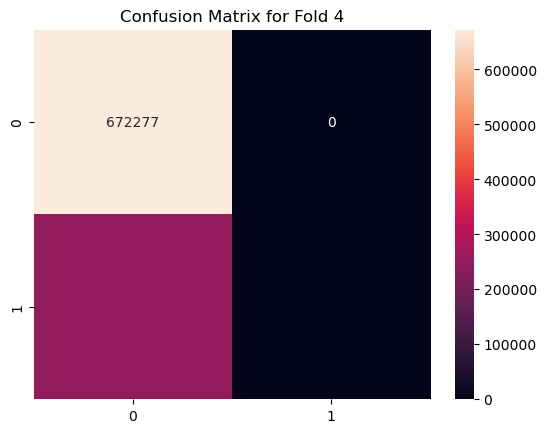

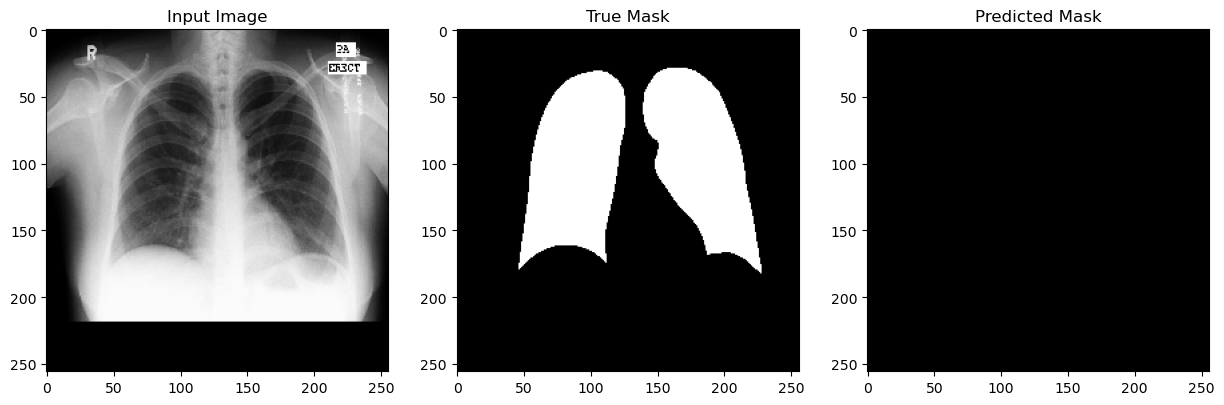

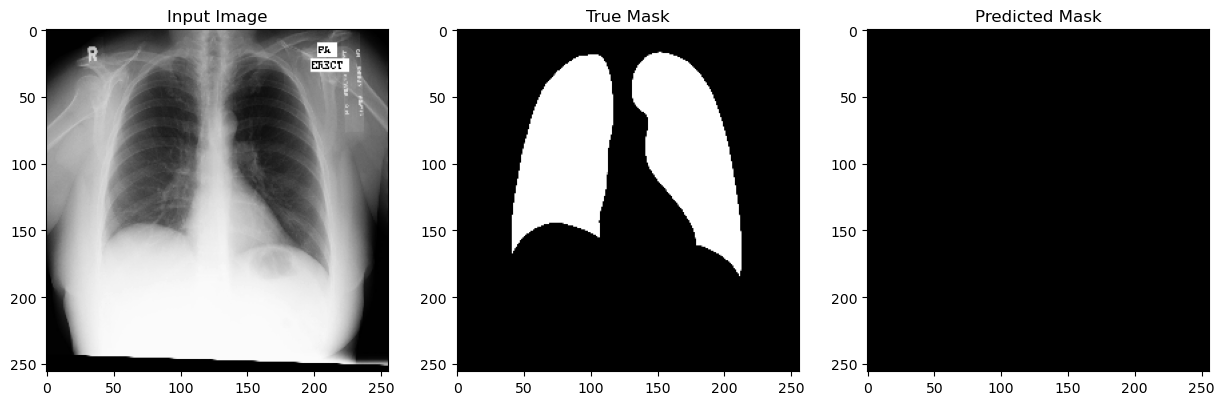

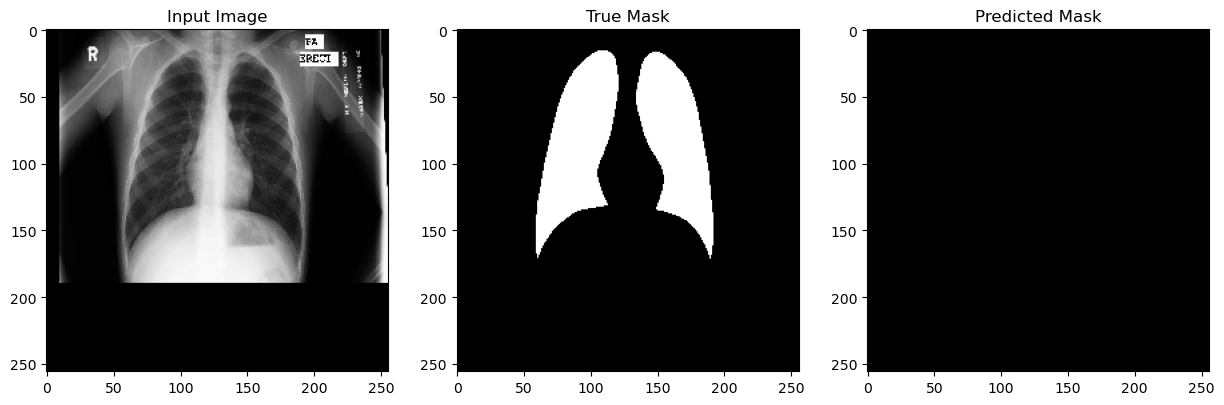

Starting fold 4...
Epoch 1/50


C:\Users\Jaber\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 578s 35s/step - accuracy: 0.7134 - loss: 0.6236 - val_accuracy: 0.7427 - val_loss: 0.4538
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 558s 35s/step - accuracy: 0.7469 - loss: 0.4630 - val_accuracy: 0.7427 - val_loss: 0.3580
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 552s 34s/step - accuracy: 0.7844 - loss: 0.4422 - val_accuracy: 0.9335 - val_loss: 0.2606
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


C:\Users\Jaber\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


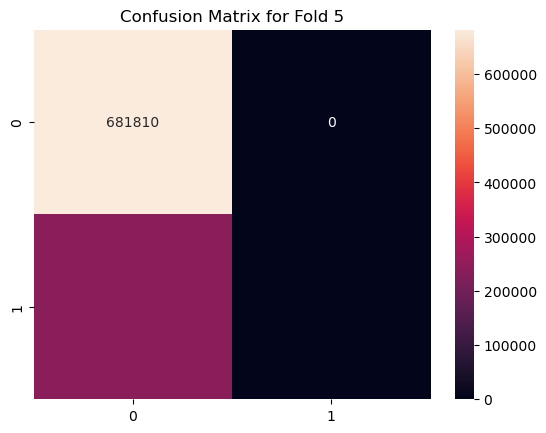

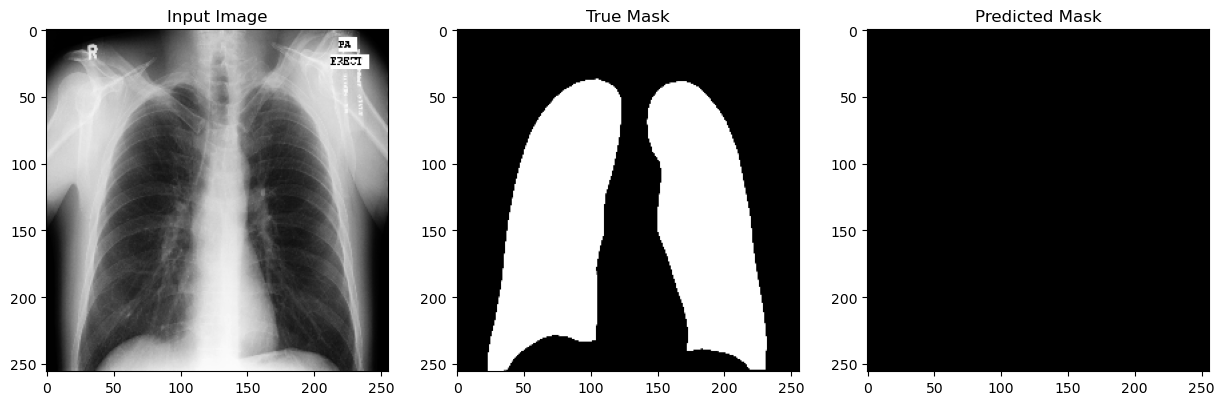

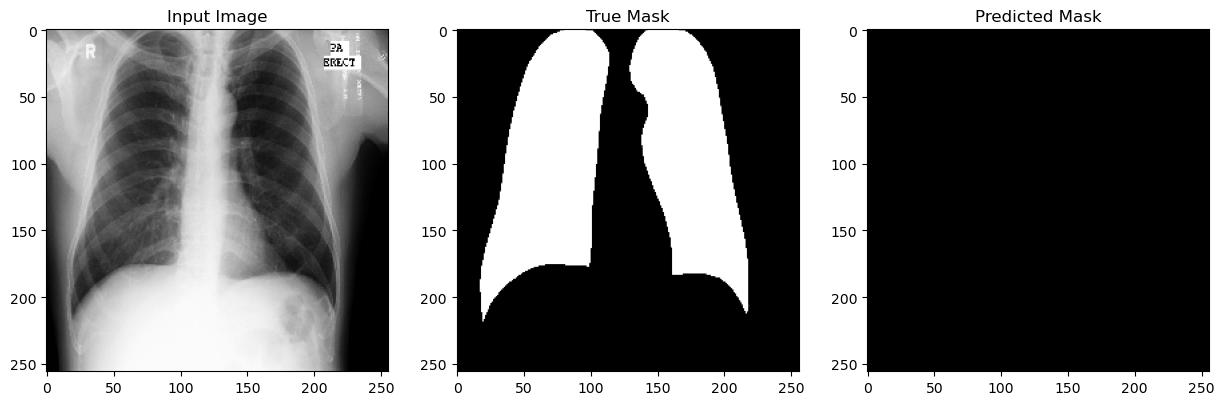

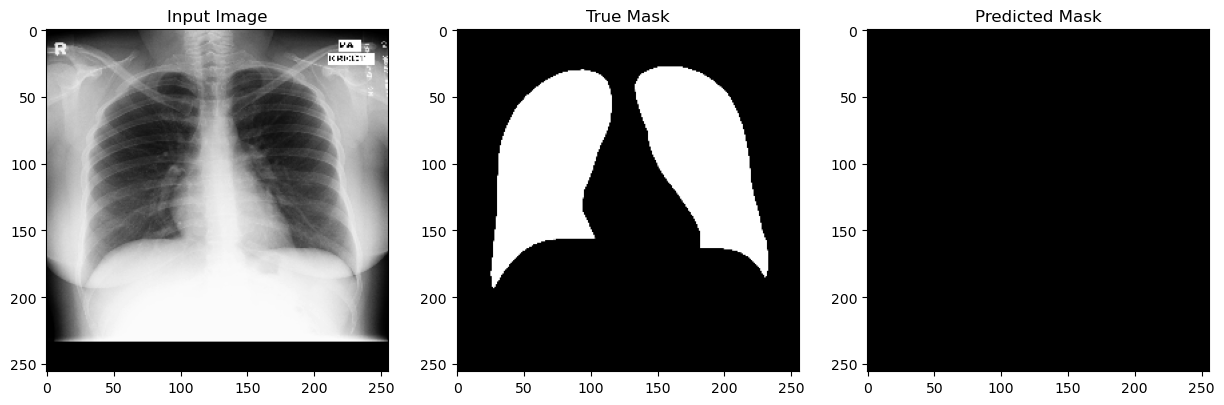

Starting fold 5...
Epoch 1/50


C:\Users\Jaber\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 573s 36s/step - accuracy: 0.7237 - loss: 0.6116 - val_accuracy: 0.7446 - val_loss: 0.4345
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 561s 35s/step - accuracy: 0.7327 - loss: 0.4887 - val_accuracy: 0.7446 - val_loss: 0.4084
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 563s 35s/step - accuracy: 0.7502 - loss: 0.4579 - val_accuracy: 0.8710 - val_loss: 0.3414
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


C:\Users\Jaber\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


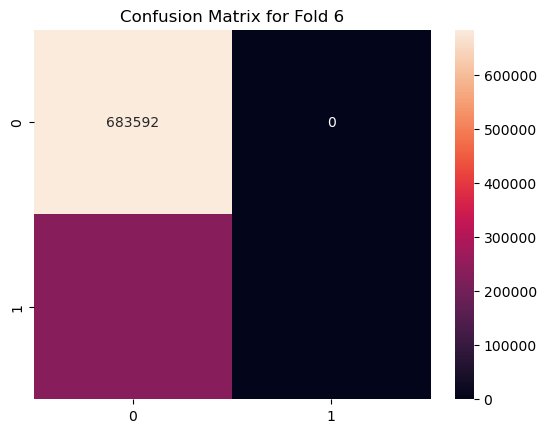

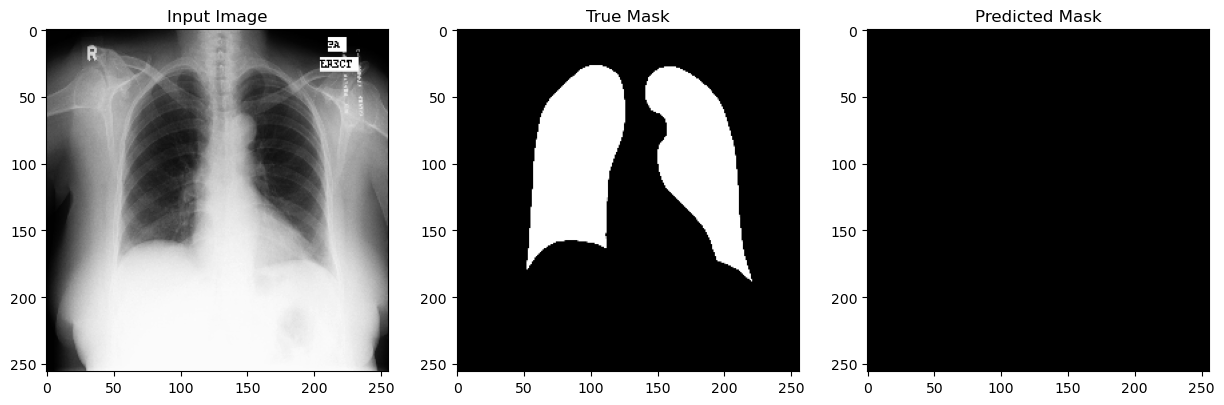

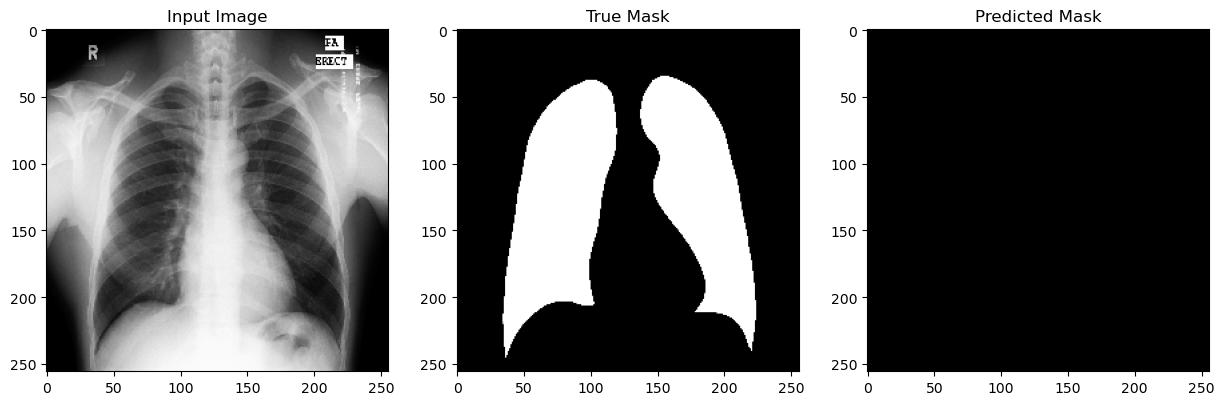

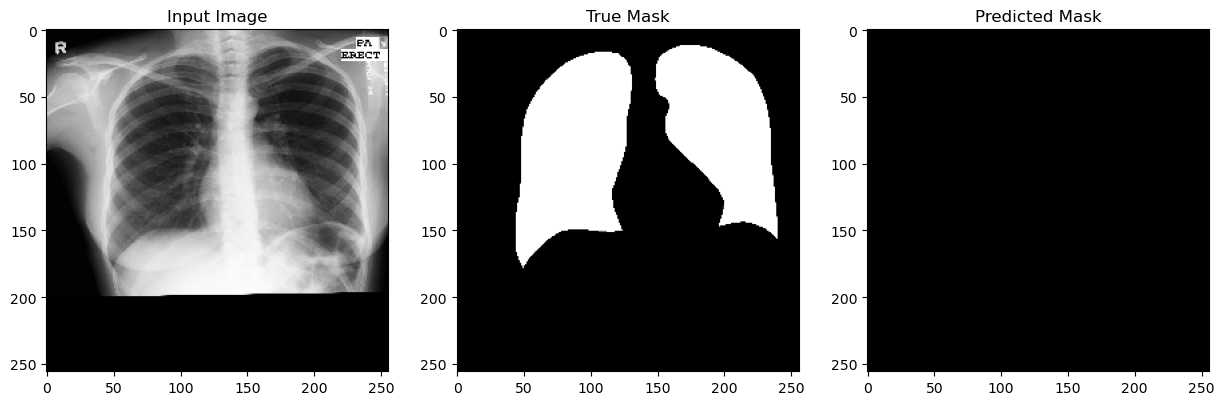

Starting fold 6...
Epoch 1/50


C:\Users\Jaber\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 575s 35s/step - accuracy: 0.7347 - loss: 0.7014 - val_accuracy: 0.7673 - val_loss: 0.5049
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 560s 35s/step - accuracy: 0.7445 - loss: 0.5141 - val_accuracy: 0.7673 - val_loss: 0.3793
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 565s 35s/step - accuracy: 0.7424 - loss: 0.4567 - val_accuracy: 0.7673 - val_loss: 0.3334
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


C:\Users\Jaber\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


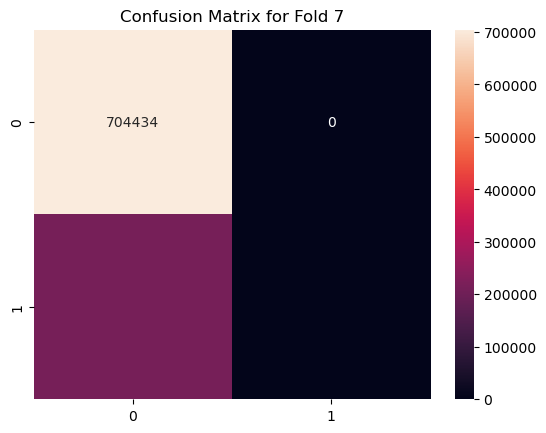

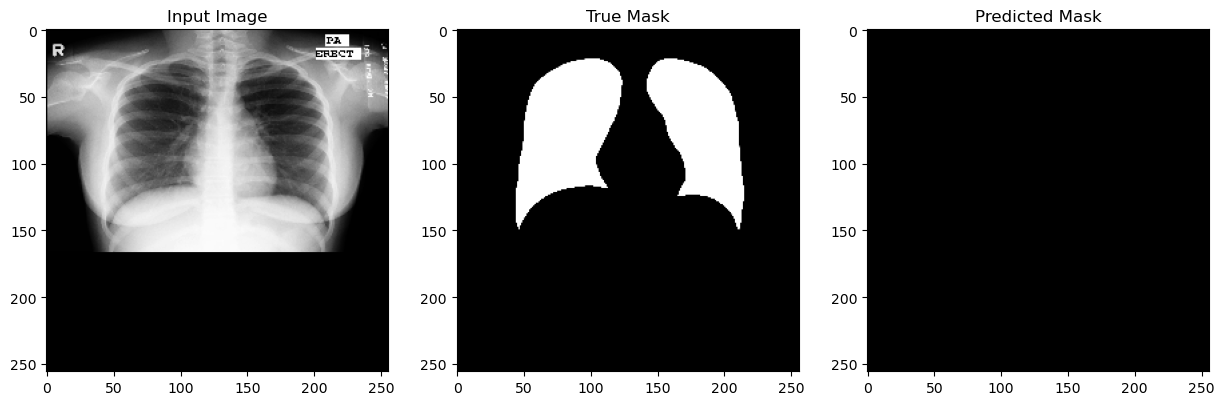

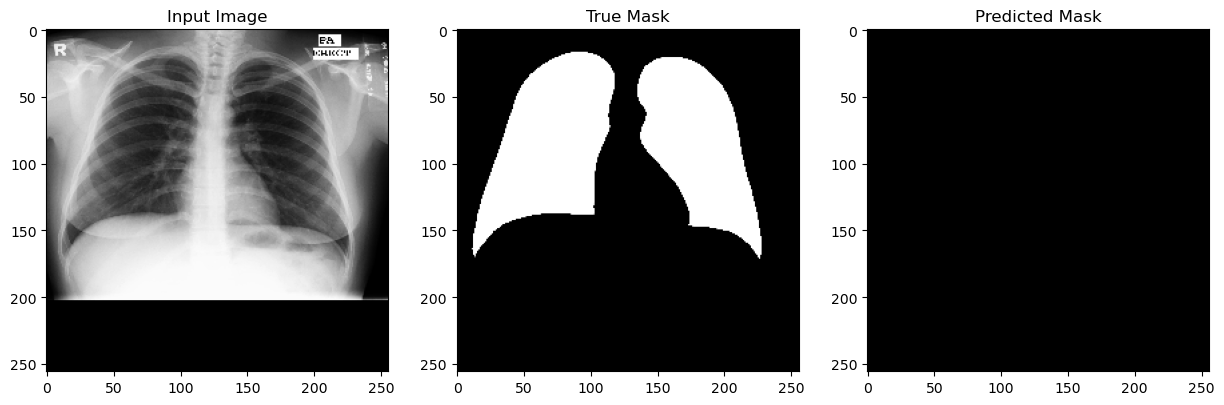

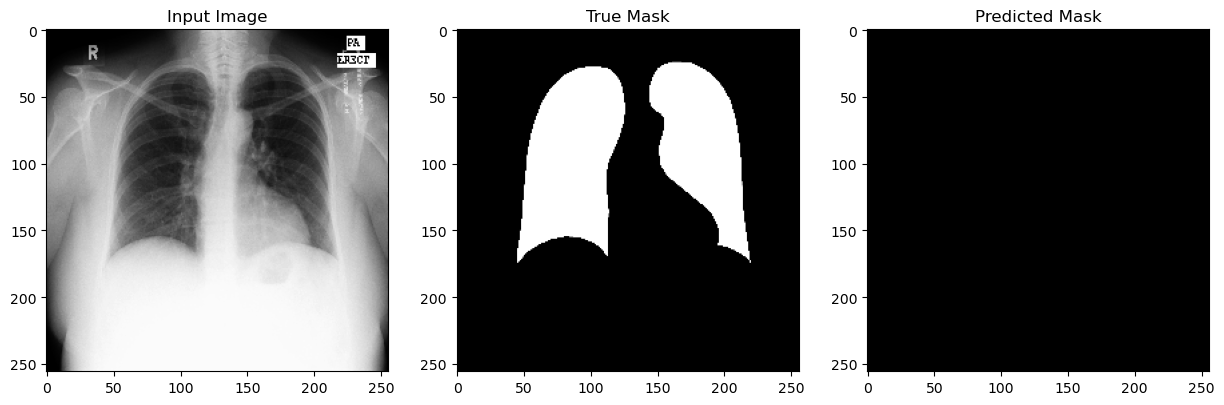

Starting fold 7...
Epoch 1/50


C:\Users\Jaber\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 573s 35s/step - accuracy: 0.6578 - loss: 0.6208 - val_accuracy: 0.7481 - val_loss: 0.4409
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 558s 35s/step - accuracy: 0.7463 - loss: 0.4687 - val_accuracy: 0.7481 - val_loss: 0.4116
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 595s 37s/step - accuracy: 0.7434 - loss: 0.4528 - val_accuracy: 0.8429 - val_loss: 0.3479
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


C:\Users\Jaber\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


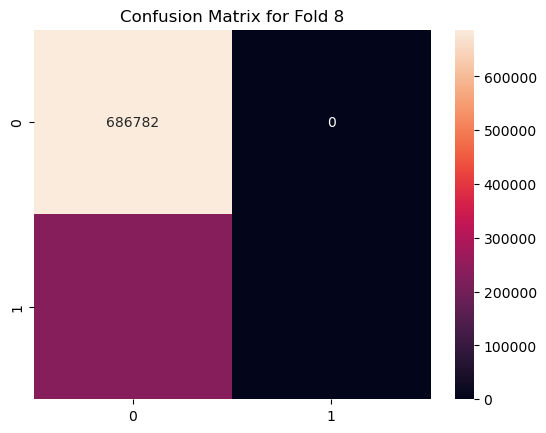

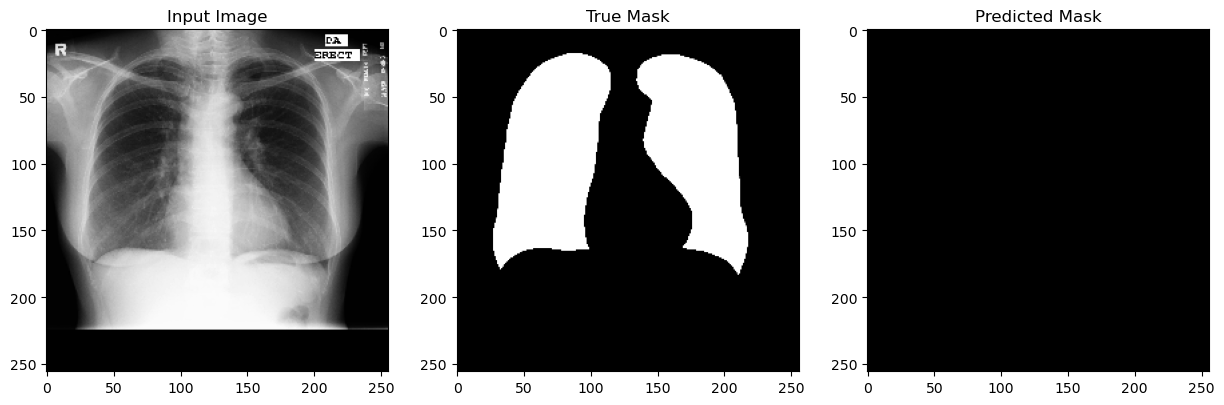

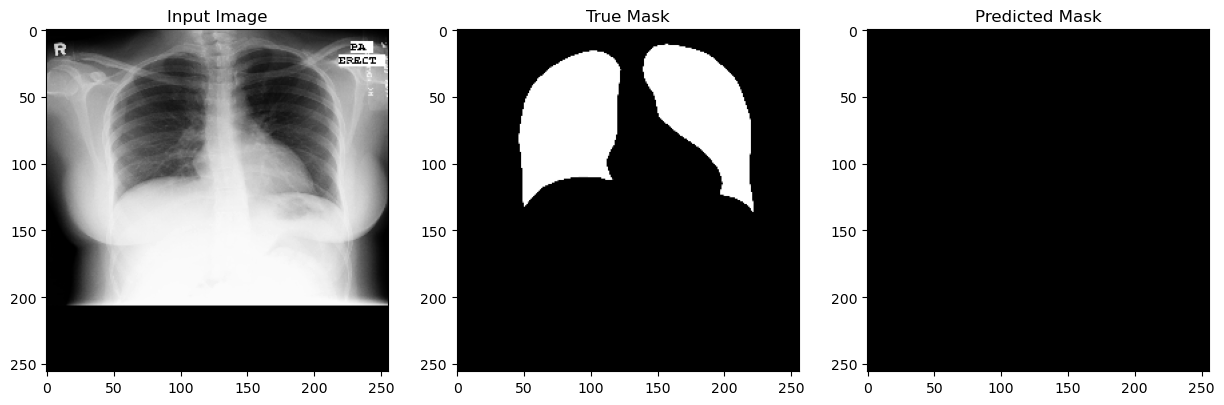

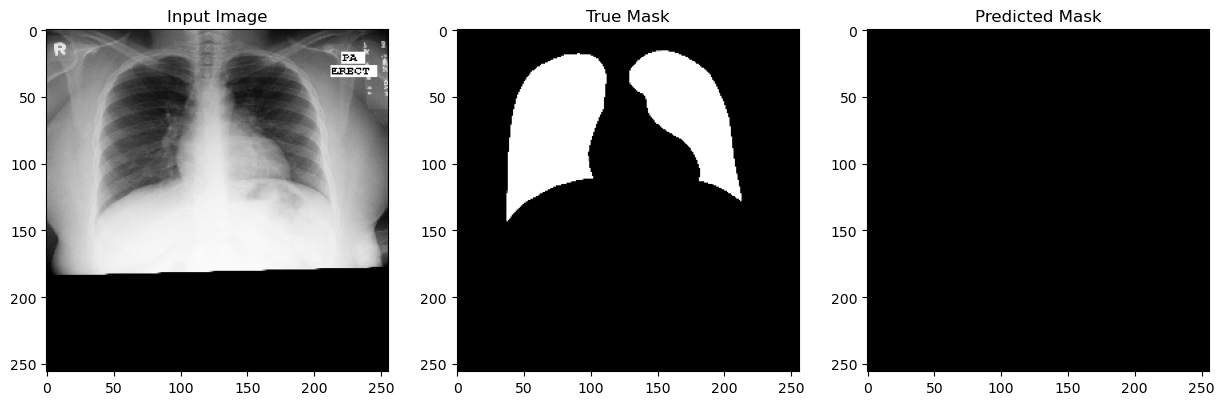

Starting fold 8...
Epoch 1/50


C:\Users\Jaber\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 687s 42s/step - accuracy: 0.6738 - loss: 0.7382 - val_accuracy: 0.7271 - val_loss: 0.5470
Epoch 2/50
10/16 ━━━━━━━━━━━━━━━━━━━━ 3:58 40s/step - accuracy: 0.7462 - loss: 0.5707

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Directories for Montgomery dataset images and masks
image_dir = r'C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Datasets\ImageSegmentation\Montgomery_Dataset\CXR_png'
left_mask_dir = r'C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Datasets\ImageSegmentation\Montgomery_Dataset\Masks_png\leftMask'
right_mask_dir = r'C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Datasets\ImageSegmentation\Montgomery_Dataset\Masks_png\rightMask'

img_size = (256, 256)

# Function to augment data
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

def load_images_and_masks(image_dir, left_mask_dir, right_mask_dir, img_size):
    images = []
    masks = []
    
    for img_name in os.listdir(image_dir):
        # No need to append .png since the filenames already have it
        img_path = os.path.join(image_dir, img_name)
        left_mask_path = os.path.join(left_mask_dir, img_name)
        right_mask_path = os.path.join(right_mask_dir, img_name)
        
        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Ensure the image is loaded correctly
        if img is None:
            print(f"Image not found: {img_path}")
            continue
        
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize image to range 0-1
        
        # Load left and right lung masks
        left_mask = cv2.imread(left_mask_path, cv2.IMREAD_GRAYSCALE)
        right_mask = cv2.imread(right_mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Ensure both masks are loaded correctly
        if left_mask is None or right_mask is None:
            print(f"Mask not found: {left_mask_path} or {right_mask_path}")
            continue
        
        left_mask = cv2.resize(left_mask, img_size)
        right_mask = cv2.resize(right_mask, img_size)
        
        # Combine left and right masks into a single mask
        combined_mask = np.maximum(left_mask, right_mask)
        combined_mask = combined_mask / 255.0  # Normalize mask to range 0-1
        
        # Append the image and the mask
        images.append(np.expand_dims(img, axis=-1))  # Add channel dimension to the image
        masks.append(np.expand_dims(combined_mask, axis=-1))  # Add channel dimension to the mask
    
    return np.array(images), np.array(masks)

# Load the images and combined masks
images, masks = load_images_and_masks(image_dir, left_mask_dir, right_mask_dir, img_size)

# Ensure data was loaded correctly
if len(images) == 0 or len(masks) == 0:
    raise ValueError("No images or masks were loaded. Check the dataset paths and file names.")

# Data augmentation function
datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# U-Net Architecture
def unet_model(input_size=(256, 256, 1)):
    inputs = tf.keras.layers.Input(input_size)
    
    # Contracting Path
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c3)
    
    # Bottleneck
    b = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    b = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(b)
    
    # Expansive Path
    u1 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(b)
    u1 = tf.keras.layers.concatenate([u1, c3])
    c4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(u1)
    c4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c4)
    
    u2 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c4)
    u2 = tf.keras.layers.concatenate([u2, c2])
    c5 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c5 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c5)
    
    u3 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c5)
    u3 = tf.keras.layers.concatenate([u3, c1])
    c6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    c6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c6)
    
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(c6)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Early stopping callback to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Arrays to store performance metrics for each fold
accuracy_scores = []
recall_scores = []
precision_scores = []
f1_scores = []
specificity_scores = []

# Track training history
train_history = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

# Loop through each fold in the 10-fold cross-validation
fold = 1
for train_index, test_index in kf.split(images):
    print(f"Starting fold {fold}...")
    fold += 1

    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = masks[train_index], masks[test_index]

    # Data augmentation
    train_gen = datagen.flow(X_train, y_train, batch_size=8)
    
    # Create the model for each fold
    model = unet_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model with early stopping
    history = model.fit(train_gen, validation_data=(X_test, y_test), epochs=50, batch_size=8, callbacks=[early_stopping], verbose=1)

    # Store training history
    train_history['accuracy'].extend(history.history['accuracy'])
    train_history['val_accuracy'].extend(history.history['val_accuracy'])
    train_history['loss'].extend(history.history['loss'])
    train_history['val_loss'].extend(history.history['val_loss'])

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(np.uint8)  # Ensure binary predictions
    
    y_test_binary = (y_test > 0.5).astype(np.uint8)  # Convert y_test to binary for comparison

    # Calculate performance metrics for this fold
    def calculate_metrics(y_true, y_pred):
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        accuracy = accuracy_score(y_true_flat, y_pred_flat)
        recall = recall_score(y_true_flat, y_pred_flat)
        precision = precision_score(y_true_flat, y_pred_flat)
        f1 = f1_score(y_true_flat, y_pred_flat)
        
        tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat).ravel()
        specificity = tn / (tn + fp)
        
        return accuracy, recall, precision, f1, specificity

    # Calculate metrics for this fold
    accuracy, recall, precision, f1, specificity = calculate_metrics(y_test_binary, y_pred)
    
    # Append metrics to the respective arrays
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)
    specificity_scores.append(specificity)
    
    # Confusion matrix for this fold
    conf_matrix = confusion_matrix(y_test_binary.flatten(), y_pred.flatten())
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title(f"Confusion Matrix for Fold {fold}")
    plt.show()

    # Visualize predictions for this fold
    for i in range(3):  # Visualize first 3 predictions
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        ax[0].imshow(X_test[i].squeeze(), cmap='gray')
        ax[0].set_title('Input Image')
        
        ax[1].imshow(y_test[i].squeeze(), cmap='gray')
        ax[1].set_title('True Mask')
        
        ax[2].imshow(y_pred[i].squeeze(), cmap='gray')
        ax[2].set_title('Predicted Mask')
        
        plt.show()

# Calculate the average performance across all 10 folds
avg_accuracy = np.mean(accuracy_scores)
avg_recall = np.mean(recall_scores)
avg_precision = np.mean(precision_scores)
avg_f1 = np.mean(f1_scores)
avg_specificity = np.mean(specificity_scores)

# Print the average performance metrics
print(f'Average Accuracy: {avg_accuracy:.4f}')
print(f'Average Recall (Sensitivity): {avg_recall:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average F1 Score: {avg_f1:.4f}')
print(f'Average Specificity: {avg_specificity:.4f}')

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_history['accuracy'], label='Train Accuracy')
plt.plot(train_history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history['loss'], label='Train Loss')
plt.plot(train_history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
